In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, sys
sys.path.insert(0, '../scripts')

from fc_helpers import make_corrfig, linearize, get_flat_inds_for_net, triangularizeweights
from data_loader import data_loader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import svm

## Load demographic and connectivity data 
#### Group labels: TS = Tourette syndrome partcipant; TFC = control partcipant

In [2]:
demo = pd.read_csv('data/demo.csv', names=['VC', 'Age', 'Group'])

demo_ts = demo.where(demo.Group=='TS').dropna().reset_index(drop=True)
demo_hc = demo.where(demo.Group=='TFC').dropna().reset_index(drop=True)

In [3]:
demo_ts

,VC,Age,Group
0,vc39607,13.00,TS
1,vc39504,9.70,TS
2,vc39703,14.60,TS
3,vc39503,11.80,TS
4,vc39771,11.10,TS
...,...,...,...
94,vc39687,24.90,TS
95,vc39746,34.06,TS
96,vc39784,30.55,TS
97,vc39845,29.79,TS


In [4]:
# custom data loader reads in connectivity data for each group seperately
ts_con = data_loader(demo_ts)
hc_con = data_loader(demo_hc)

Shape of loaded data: ts-(352, 352, 99); hc-(352, 352, 99)

Functional connectivity data is essentialy just correlation matricies, based off measured brain activity
at different locations. Here we are recordinig from 352 regions in the brain, and take the pairwise correlation 
between each timeseries. The result is a 352 x 352 correlation matrix. We load this matrix for each participant
in the data set (n = 99 HC, n = 99 TS)

The average connectivity for a group can be calculated and shown


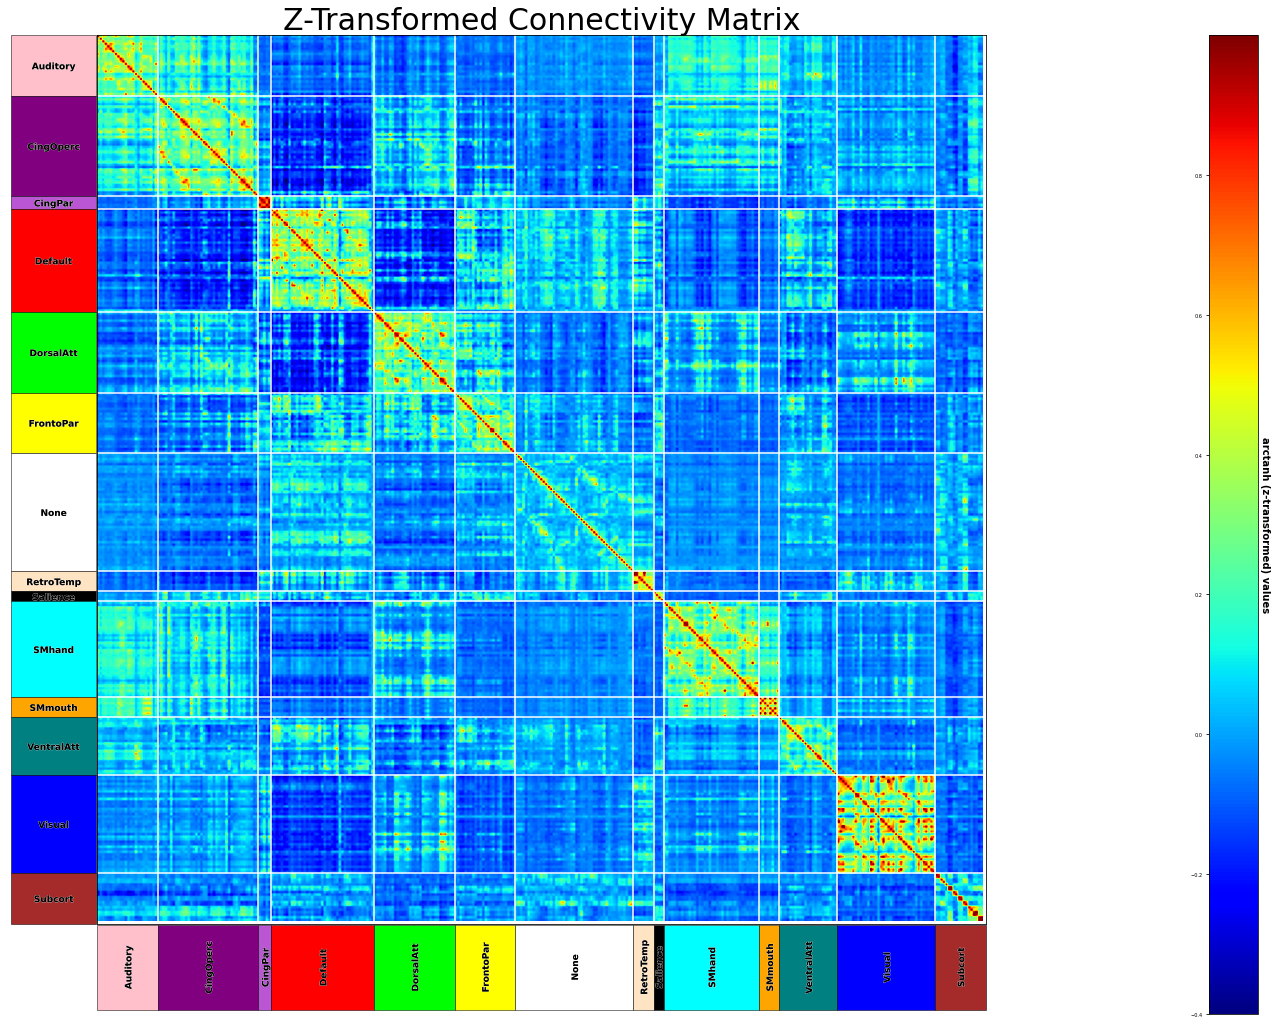

In [5]:
print(f"Shape of loaded data: ts-{ts_con.shape}; hc-{hc_con.shape}\n")

print("""Functional connectivity data is essentialy just correlation matricies, based off measured brain activity
at different locations. Here we are recordinig from 352 regions in the brain, and take the pairwise correlation 
between each timeseries. The result is a 352 x 352 correlation matrix. We load this matrix for each participant
in the data set (n = 99 HC, n = 99 TS)\n""")

print("The average connectivity for a group can be calculated and shown")

average_ts_connectivity = np.mean(ts_con,2)
make_corrfig(average_ts_connectivity)


In [154]:
# Connectivity matricies are symettric and square. We need just the flattened upper or lower triangle, of the matrix
# to create a new design matrix

ts_con_flat = linearize(ts_con)
hc_con_flat = linearize(hc_con)


# create feature matrix
X = np.vstack((hc_con_flat, ts_con_flat))

# create label vector: 1 for HC, -1 for TS
y = np.concatenate((np.repeat(1,99), np.repeat(-1,99)))

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

## Classification  
#### LOOCV with SVM (C = 1) 

In [25]:
cv = LeaveOneOut()
clf = svm.SVC(kernel='linear', C=1, random_state=1)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-2)
print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

LOOCV Accuracy: 0.672 (0.470)


In [52]:
# Use scaled dataframe
scores = cross_val_score(clf, X_scale, y, scoring='accuracy', cv=cv, n_jobs=-2)
print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

LOOCV Accuracy: 0.682 (0.466)


#### Feature Importance

#### Save coefficients across LOOCV folds

In [85]:
cv = LeaveOneOut()
scores = []
cv_fold_weights = []

for train_ix, test_ix in cv.split(X_scale):
    
    X_train, X_test = X_scale[train_ix, :], X_scale[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    clf_svm = svm.SVC(kernel='linear', C=1, random_state=1)
    clf.fit(X_train, y_train)
    
    cv_fold_weights.append(clf.coef_)
    scores.append(clf.score(X_test, y_test))

In [88]:
print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

LOOCV Accuracy: 0.682 (0.466)


In [112]:
mean_coeffcients = np.vstack(cv_fold_weights).mean(0)

#### Visualize mean feature weight, plotted ontop of correlation matrix features

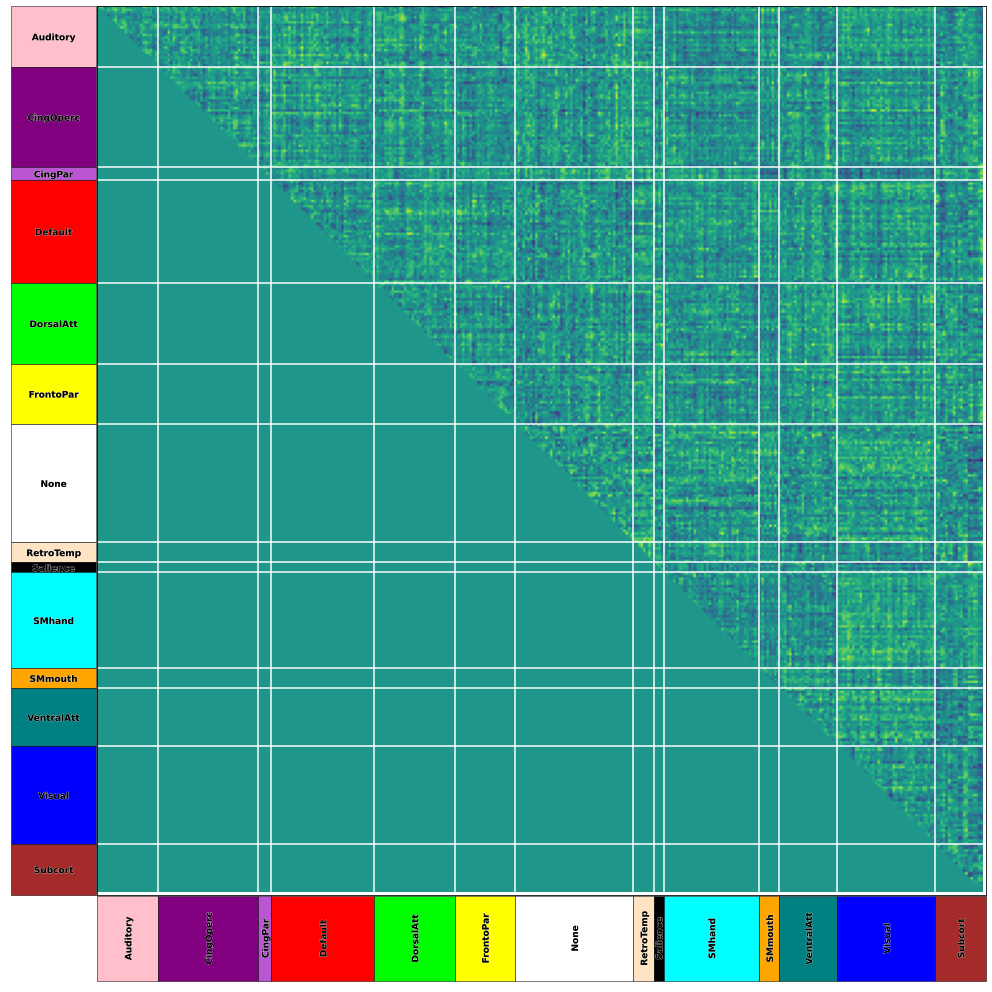

In [153]:
make_corrfig(triangularizeweights(mean_coeffcients), weights=True)

The important features for classsifcaiton performance are scattered across the brain. Below we take the mean of the features corresponding to specific functional networks, and plot that. 

In [137]:
netlist = ['Auditory','CingOperc','CingPar','Default','DorsalAtt','FrontoPar','None', 'RetroTemp','Salience','SMhand','SMmouth','VentralAtt','Visual','Subcort']   

mean_importance = []
net_size = []
for net in netlist:
    mean_importance.append(np.mean(mean_coeffcients[get_flat_inds_for_net(net, within=True)]))
    net_size.append(len(get_flat_inds_for_net(net, within=True)))


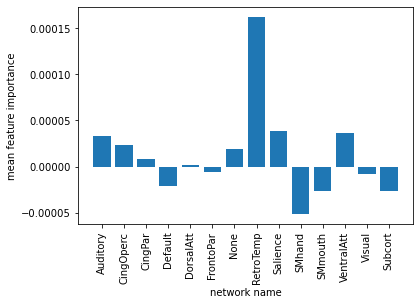

In [148]:
plt.bar(range(len(netlist)), mean_importance, align='center')
plt.xticks(range(len(netlist)), netlist, rotation=90)
plt.ylabel("mean feature importance")
plt.xlabel('network name')
plt.show()

From this it looks like the RetroTemporal Network is the most important for classification of TS. However, the number of features in a network may impact the importance of that network. 

By plotting network size, versus mean feature importance, we can investigate this.

Given the small n, we can't be sure of any trend here, but there is reason to be speculative. 

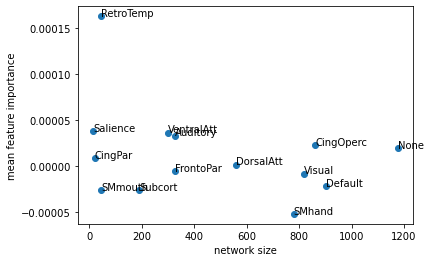

In [150]:
fig, ax = plt.subplots()
plt.scatter(net_size, mean_importance)
plt.ylabel("mean feature importance")
plt.xlabel("network size")
for i, txt in enumerate(netlist):
        ax.annotate(txt,(net_size[i], mean_importance[i]))   